In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# Rapid VO
# from socket import gaierror
import cv2 as cv
import numpy as np
# import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

import DataHandler

# Initiate ORB detector
# max features
nFeatures = 1000
orb = cv.ORB_create(nFeatures, scoreType=cv.ORB_FAST_SCORE)



In [3]:
def pose_update():
    pass


def motion_prediction():
    pass


def keyframe():
    pass



## acquire images


<class 'numpy.ndarray'>


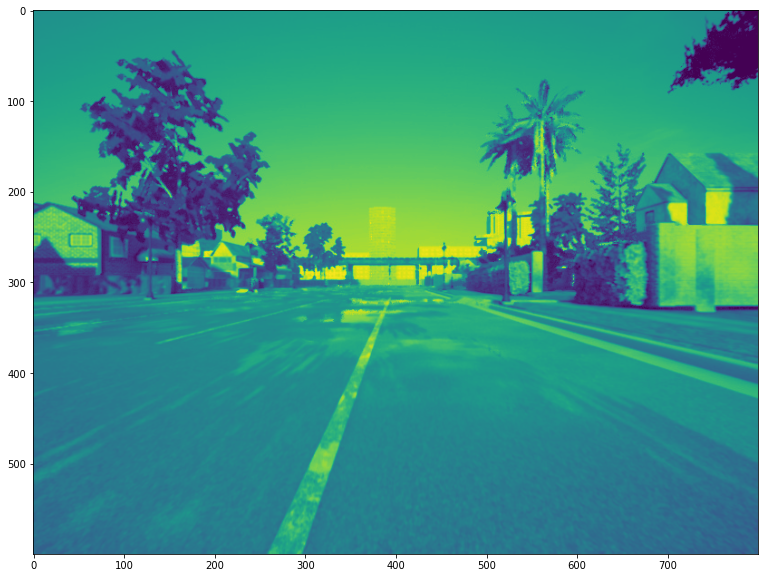

In [4]:
handle = DataHandler.DataHandler(50, 200, "/home/hortenbach/workspace/MA_v3/py/pic/pictures/wetsunset/")

gray_A = iter(handle.gray_img_A)
gray_B = iter(handle.gray_img_B)
depth  = iter(handle.depth)

print(type(handle.gray_img_A[0]))
plt.imshow(handle.gray_img_A[0])

<class 'numpy.ndarray'>


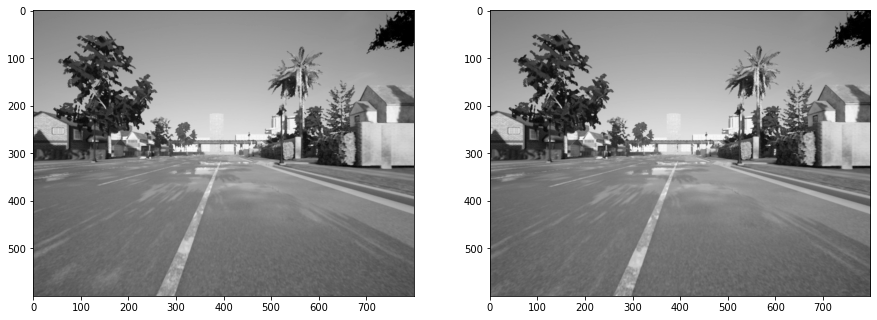

In [5]:
# Iterate
img_A_t0 = next(gray_A)
img_A_t1 = next(gray_A)
img_B = next(gray_B)
img_D = next(depth)
# display images
fig, ax = plt.subplots(1,2)

print(type(img_A_t0))

ax[0].imshow(img_A_t0, cmap='gray')
ax[1].imshow(img_A_t1, cmap='gray')

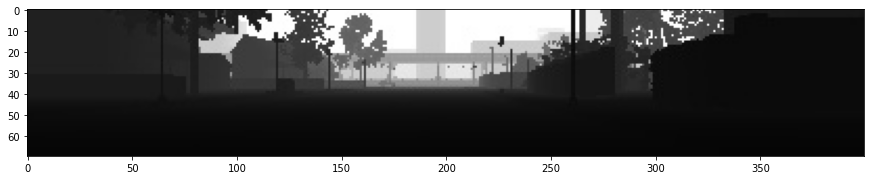

In [6]:
# display images
plt.imshow(img_D, cmap='gray')


## detect features in t0 and t+1 of left camera

In [7]:
def feature_detection(img, detector):
    """ Detect Features """
    max_num_of_best_corners = 500
    if detector == 'ORB':
        # find the keypoints with ORB
        kp = orb.detect(img, None)
    elif detector == 'GFTT':
        corners = cv.goodFeaturesToTrack(img, max_num_of_best_corners, 0.01, 10)
        kp = [cv.KeyPoint(pt[0][0], pt[0][1], 3) for pt in corners]
    return kp

gftt_kp1 = feature_detection(img_A_t0, 'GFTT')
gftt_kp2 = feature_detection(img_A_t1, 'GFTT')

#orb_kp = feature_detection(img, 'ORB')

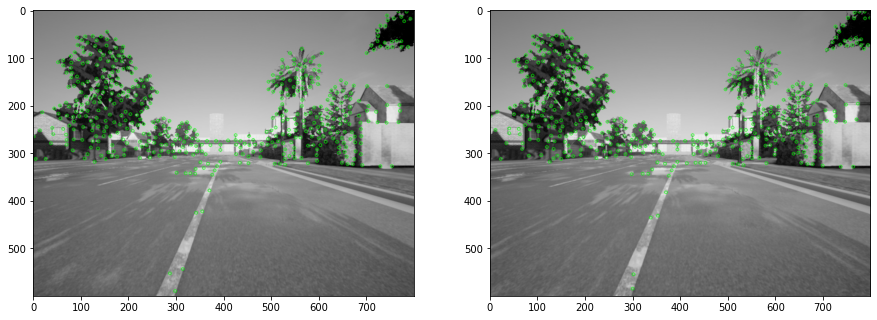

In [8]:
# draw only keypoints location,not size and orientation
img2 = cv.drawKeypoints(img_A_t0, gftt_kp1, None, color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
img3 = cv.drawKeypoints(img_A_t1, gftt_kp2, None, color=(0,255,0), flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img2, cmap='gray')
ax[1].imshow(img3, cmap='gray')


## extract gftt features into orb descriptors

In [9]:
def feature_extraction(img, kp):
    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)
    return [kp, des]

orb_kp1, des1 = feature_extraction(img_A_t0, gftt_kp1)
orb_kp2, des2 = feature_extraction(img_A_t1, gftt_kp2)

## match feature descitpors of image t0  with image t+1 BRUTE FORCE
+ First without cross checking
+ Second with cross checking

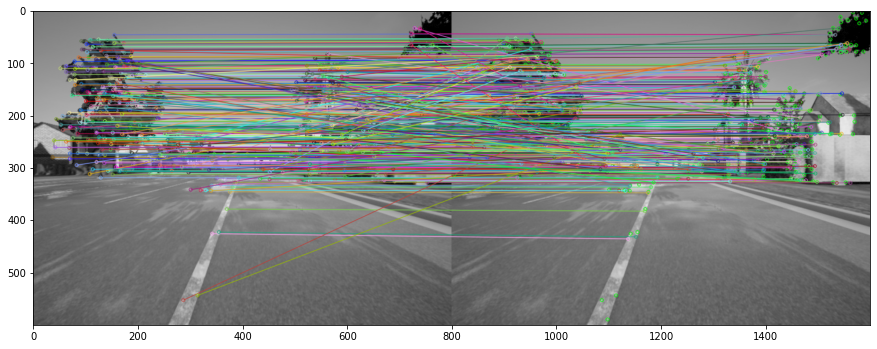

(<matplotlib.image.AxesImage at 0x7fc74c104bb0>, None)

In [10]:
def brute_matching(img1, img2, kp1, kp2, des1, des2):

    # create BFMatcher object
    # Use distance measurement cv2.NORM_HAMMING creates a BFMatcher object (because we are using ORB) and turns on cross checking for better results.
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)

    # Use the Matcher.match() method to get the best match in the two images.
    # The returned result matches is a list of DMatch objects. This DMatch object has the following properties:
    # DMatch.distance - distance between descriptors. The lower the better.
    # DMatch.trainIdx - index of descriptor in training descriptor
    # DMatch.queryIdx - the index of the descriptor in the query descriptor
    # DMatch.imgIdx - index of the training image.

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    return sorted(matches, key = lambda x:x.distance)

bf_matches = brute_matching(img_A_t0, img_A_t1, orb_kp1, orb_kp2, des1, des2)
# Draw first all matches.
img_bf = cv.drawMatches(img_A_t0, orb_kp1, img2, orb_kp2, bf_matches, None, flags=2)


plt.imshow(img_bf),plt.show()

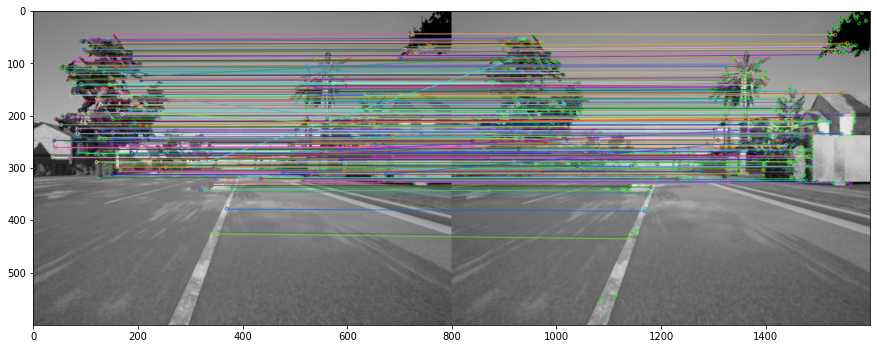

(<matplotlib.image.AxesImage at 0x7fc74c0eea00>, None)

In [11]:
def brute_matching(img1, img2, kp1, kp2, des1, des2):

    # create BFMatcher object
    # Use distance measurement cv2.NORM_HAMMING creates a BFMatcher object (because we are using ORB) and turns on cross checking for better results.
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

    # Use the Matcher.match() method to get the best match in the two images.
    # The returned result matches is a list of DMatch objects. This DMatch object has the following properties:
    # DMatch.distance - distance between descriptors. The lower the better.
    # DMatch.trainIdx - index of descriptor in training descriptor
    # DMatch.queryIdx - the index of the descriptor in the query descriptor
    # DMatch.imgIdx - index of the training image.

    # Match descriptors.
    matches = bf.match(des1,des2)

    # Sort them in the order of their distance.
    return sorted(matches, key = lambda x:x.distance)

good_matches = brute_matching(img_A_t0, img_A_t1, orb_kp1, orb_kp2, des1, des2)
# Draw first all matches.
img_bf = cv.drawMatches(img_A_t0, orb_kp1, img2, orb_kp2, good_matches, None, flags=2)


plt.imshow(img_bf),plt.show()

## match feature descitpors of image t0  with image t+1 FLANN

In [12]:
def feature_matching(img1, img2, kp1, kp2, des1, des2):
    # Using Flann with ORB Descriptors
    FLANN_INDEX_LSH = 6
    index_params = dict(algorithm=FLANN_INDEX_LSH,
                        table_number=6,  # 12
                        key_size=12,     # 20
                        multi_probe_level=1)  # 2
    search_params = dict(checks=50)   # or pass empty dictionary

    # flann = cv.FlannBasedMatcher(index_params,search_params)

    des1 = np.float32(des1)
    des2 = np.float32(des2)
    # matches = flann.knnMatch(des1,des2,k=2)

    # -- Step 2: Matching descriptor vectors with a FLANN based matcher
    # Since SURF is a floating-point descriptor NORM_L2 is used
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
    matches = matcher.knnMatch(des1, des2, 2)

    return matches


FLANN_matches = feature_matching(img_A_t0, img_A_t1, orb_kp1, orb_kp2, des1, des2)

## remove outliers and keep only good matches

In [13]:
def outlier_removal(matches, kp1 ,kp2):
    pts1 = []
    pts2 = []
    print(f"Original {len(matches)} matches.")
    # ratio test as per Lowe's paper
    ratio_thresh = 0.8
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append([m])
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
    print(f"good {len(good_matches)} matches.")
    return good_matches, pts1, pts2

#good_matches, pts1, pts2 = outlier_removal(matches, orb_kp1, orb_kp2)
# -- Draw matches
# all matches
#img_matches = cv.drawMatchesKnn(img_A_t0, orb_kp1, img_A_t1, orb_kp2, matches,
#                                None, flags=cv.DrawMatchesFlags_DEFAULT)
# good matches
#img_good_matches = cv.drawMatchesKnn(img_A_t0, orb_kp1, img_A_t1, orb_kp2, good_matches,
#                                None, flags=cv.DrawMatchesFlags_DEFAULT)


In [14]:
type(good_matches[0])

cv2.DMatch

In [15]:
print(good_matches[0])

<DMatch 0x7fc74c13d790>


In [17]:
# # examine Fundamental Matrix
# pts1 = np.int32(pts1)
# pts2 = np.int32(pts2)
# F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
# print("Fundamental Matrix F: \n", F)

def drawlines(img1: np.ndarray, img2: np.ndarray, lines, pts1, pts2):
  ''' img1 - image on which we draw the epilines for the points in img2
  lines - corresponding epilines '''

  colors = np.random.rand(50,3)
  num_colors = colors.shape[0]

  r,c, _ = img1.shape

  for i, (r,pt1,pt2) in enumerate(zip(lines,pts1,pts2)):
    color = colors[i % num_colors]
    color = tuple(color.tolist())
    x0,y0 = map(int, [0, -r[2]/r[1] ])
    x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
    img1 = cv.line(img1, (x0,y0), (x1,y1), color,10)
    img1 = cv.circle(img1,tuple(pt1),20,color,-1)
    img2 = cv.circle(img2,tuple(pt2),20,color,-1)
  return img1,img2

def draw_epilines(pts1: np.ndarray, pts2: np.ndarray, img1: np.ndarray, img2: np.ndarray, F: np.ndarray) -> np.ndarray:
	# Find epilines corresponding to points in right image (second image) and
	# drawing its lines on left image
	lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
	lines1 = lines1.reshape(-1,3)
	img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
	# Find epilines corresponding to points in left image (first image) and
	# drawing its lines on right image
	lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
	lines2 = lines2.reshape(-1,3)
	img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
	plt.subplot(121),plt.imshow(img5)
	plt.subplot(122),plt.imshow(img3)
	plt.show()


k = np.array([[640, 0, 640],
              [0, 480, 480],
              [0,   0,   1]], dtype=np.float32)

def get_fmat_from_emat(i2_E_i1: np.ndarray, K1: np.ndarray, K2: np.ndarray) -> np.ndarray:
	""" """
	i2_F_i1 = np.linalg.inv(K2).T @ i2_E_i1 @ np.linalg.inv(K1)
	return i2_F_i1

cam2_E_cam1, inlier_mask = cv.findEssentialMat(orb_kp1, orb_kp2, k, method=cv.RANSAC, threshold=0.1)
print('Num inliers: ', inlier_mask.sum()) ### prints "Num inliers: 8"
cam2_F_cam1 = get_fmat_from_emat(cam2_E_cam1, K1=k, K2=k)
draw_epilines(orb_kp1, orb_kp1, img_A_t0, img_A_t1, cam2_F_cam1)

TypeError: only size-1 arrays can be converted to Python scalars

## for stereo camera images compute disparity map

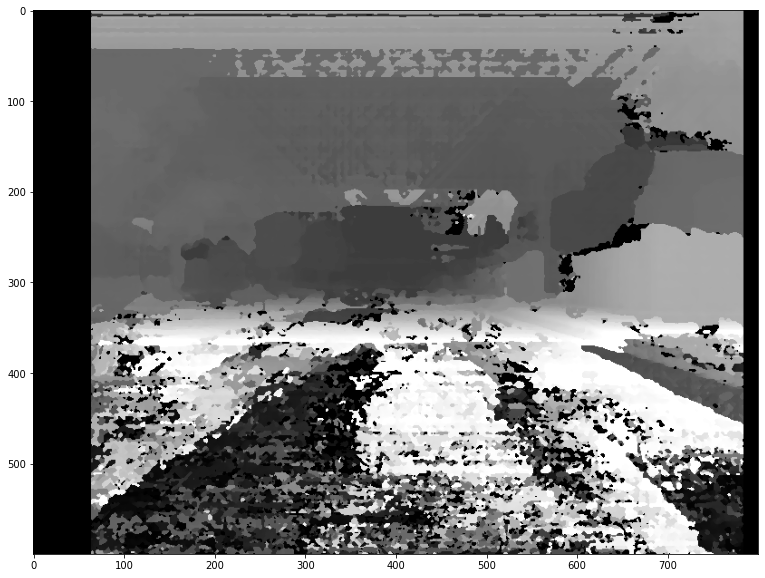

In [18]:
def calc_depthmap(img_A, img_B):
  DIR = '/home/hortenbach/workspace/MA_v2/py/pic/disparity'
  # E =  K'^T F K
  #Set disparity parameters
  #Note: disparity range is tuned according to specific parameters obtained through trial and error. 
  win_size = 5
  min_disp = -16
  max_disp = 64 #min_disp * 9
  num_disp = max_disp - min_disp # Needs to be divisible by 16
  #Create Block matching object. 
  stereo = cv.StereoSGBM_create(minDisparity= min_disp,
                numDisparities = num_disp,
                blockSize = 5,
                uniquenessRatio = 0,
                speckleWindowSize = 5,
                speckleRange = 16,
                disp12MaxDiff = 16,
                P1 = 8*3*win_size**2,#8*3*win_size**2,
                P2 =32*3*win_size**2) #32*3*win_size**2)
  #Compute disparity map
  disparity_map = stereo.compute(img_A, img_B)

  return disparity_map

disparity_map = calc_depthmap(img_A_t0, img_B) 

plt.imshow(disparity_map, 'gray')

In [19]:
import time 

CamL= img_A_t0
CamR= img_B

# Reading the mapping values for stereo image rectification
cv_file = cv.FileStorage("data/stereo_rectify_maps.xml", cv.FILE_STORAGE_READ)
Left_Stereo_Map_x = cv_file.getNode("Left_Stereo_Map_x").mat()
Left_Stereo_Map_y = cv_file.getNode("Left_Stereo_Map_y").mat()
Right_Stereo_Map_x = cv_file.getNode("Right_Stereo_Map_x").mat()
Right_Stereo_Map_y = cv_file.getNode("Right_Stereo_Map_y").mat()
cv_file.release()

def nothing(x):
    pass

cv.namedWindow('disp',cv.WINDOW_NORMAL)
cv.resizeWindow('disp',600,600)

cv.createTrackbar('numDisparities','disp',1,17,nothing)
cv.createTrackbar('blockSize','disp',5,50,nothing)
cv.createTrackbar('preFilterType','disp',1,1,nothing)
cv.createTrackbar('preFilterSize','disp',2,25,nothing)
cv.createTrackbar('preFilterCap','disp',5,62,nothing)
cv.createTrackbar('textureThreshold','disp',10,100,nothing)
cv.createTrackbar('uniquenessRatio','disp',15,100,nothing)
cv.createTrackbar('speckleRange','disp',0,100,nothing)
cv.createTrackbar('speckleWindowSize','disp',3,25,nothing)
cv.createTrackbar('disp12MaxDiff','disp',5,25,nothing)
cv.createTrackbar('minDisparity','disp',5,25,nothing)

# Creating an object of StereoBM algorithm
stereo = cv.StereoBM_create()

while True:
		imgL_gray = img_A_t0
		imgR_gray = img_B

		# Updating the parameters based on the trackbar positions
		numDisparities = cv.getTrackbarPos('numDisparities','disp')*16
		blockSize = cv.getTrackbarPos('blockSize','disp')*2 + 5
		preFilterType = cv.getTrackbarPos('preFilterType','disp')
		preFilterSize = cv.getTrackbarPos('preFilterSize','disp')*2 + 5
		preFilterCap = cv.getTrackbarPos('preFilterCap','disp')
		textureThreshold = cv.getTrackbarPos('textureThreshold','disp')
		uniquenessRatio = cv.getTrackbarPos('uniquenessRatio','disp')
		speckleRange = cv.getTrackbarPos('speckleRange','disp')
		speckleWindowSize = cv.getTrackbarPos('speckleWindowSize','disp')*2
		disp12MaxDiff = cv.getTrackbarPos('disp12MaxDiff','disp')
		minDisparity = cv.getTrackbarPos('minDisparity','disp')
		
		# Setting the updated parameters before computing disparity map
		stereo.setNumDisparities(numDisparities)
		stereo.setBlockSize(blockSize)
		stereo.setPreFilterType(preFilterType)
		stereo.setPreFilterSize(preFilterSize)
		stereo.setPreFilterCap(preFilterCap)
		stereo.setTextureThreshold(textureThreshold)
		stereo.setUniquenessRatio(uniquenessRatio)
		stereo.setSpeckleRange(speckleRange)
		stereo.setSpeckleWindowSize(speckleWindowSize)
		stereo.setDisp12MaxDiff(disp12MaxDiff)
		stereo.setMinDisparity(minDisparity)

		# Calculating disparity using the StereoBM algorithm
		disparity = stereo.compute(imgL_gray, imgR_gray)
		# NOTE: Code returns a 16bit signed single channel image,
		# CV_16S containing a disparity map scaled by 16. Hence it 
		# is essential to convert it to CV_32F and scale it down 16 times.

		# Converting to float32 
		disparity = disparity.astype(np.float32)

		# Scaling down the disparity values and normalizing them 
		disparity = (disparity/16.0 - minDisparity)/numDisparities

		# Displaying the disparity map
		cv.imshow("disp",disparity)

		# Close window using esc key
		if cv.waitKey(1) == 27:
			break
		else:
			time.sleep(0.5)

error: OpenCV(4.2.0) ../modules/calib3d/src/stereobm.cpp:1112: error: (-211:One of the arguments' values is out of range) preFilterType must be = CV_STEREO_BM_NORMALIZED_RESPONSE in function 'compute'


## Motion estimation

In [ ]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []
    
    objectpoints = []
    
    #Peek Iteration through the matched features
    m = match[0]
    print("Peek match :", m)
    # Get the pixel coordinates of features f[k - 1] and f[k]
    u1, v1 = kp1[m.queryIdx].pt
    u2, v2 = kp2[m.trainIdx].pt
    
    print(f"[kp t+0] (v1|u1) : ({v1}|{u1})")
    print(f"[kp t+1] (v2|u2) : ({v2}|{u2})")
    
    print("Depth for kp t+0: ", depth1[int(v1), int(u1)])
    
    # Iterate through the matched features
    for m in match:
        #m = m[0]
        # Get the pixel coordinates of features f[k - 1] and f[k]
        u1, v1 = kp1[m.queryIdx].pt
        u2, v2 = kp2[m.trainIdx].pt

        # Get the scale of features f[k - 1] from the depth map
        s = depth1[int(v1), int(u1)]
        
        # Check for valid scale values
        if s < 1000:
            # Calc X 
            # Transform pixel coordinates to camera coordinates using the pinhole camera model
            p_c = np.linalg.inv(k) @ (s * np.array([u1, v1, 1]))
            
            # Save the results
            image1_points.append([u1, v1])
            image2_points.append([u2, v2])
            objectpoints.append(p_c)
        
    # Convert lists to numpy arrays
    objectpoints = np.vstack(objectpoints)
    imagepoints = np.array(image2_points)
    
    print("We created a set of 3D points for cameracoordinates for t+0 :\n\n", objectpoints.shape, objectpoints[0])
    print("\n\nWe also made a set of 2D image points for t+1:\n", imagepoints.shape, imagepoints[0])
    
    # Determine the camera pose from the Perspective-n-Point solution using the RANSAC scheme
    _, rvec, tvec, _ = cv.solvePnPRansac(objectpoints, imagepoints, k, None)
    
    # Convert rotation vector to rotation matrix
    rmat, _ = cv.Rodrigues(rvec)
    
    return rmat, tvec, image1_points, image2_points

 
rmat, tvec, image1_points, image2_points = estimate_motion(good_matches, orb_kp1, orb_kp2, k, depth1=disparity_map)


Peek match : <DMatch 0x7f9b2aefa250>
[kp t+0] (v1|u1) : (282.0|393.0)
[kp t+1] (v2|u2) : (282.0|393.0)
Depth for kp t+0:  36
We created a set of 3D points for cameracoordinates for t+0 :

 (364, 3) [-13.89374967 -14.8499989   36.        ]


We also made a set of 2D image points for t+1:
 (364, 2) [393. 282.]


In [ ]:
match = good_matches
kp1 = orb_kp1
kp2 = orb_kp2
depth1=disparity_map

rmat = np.eye(3)
tvec = np.zeros((3, 1))
image1_points = []
image2_points = []

objectpoints = []

# Iterate through the matched features
for m in match:
    #m = m[0]
    # Get the pixel coordinates of features f[k - 1] and f[k]
    u1, v1 = kp1[m.queryIdx].pt
    u2, v2 = kp2[m.trainIdx].pt

    # Get the scale of features f[k - 1] from the depth map
    s = depth1[int(v1), int(u1)]

    # Check for valid scale values
    if s < 1000:
        # Transform pixel coordinates to camera coordinates using the pinhole camera model
        p_c = np.linalg.inv(k) @ (s * np.array([u1, v1, 1]))

        # Save the results
        image1_points.append([u1, v1])
        image2_points.append([u2, v2])
        objectpoints.append(p_c)

# Convert lists to numpy arrays
objectpoints = np.vstack(objectpoints)
imagepoints = np.array(image2_points)


# Determine the camera pose from the Perspective-n-Point solution using the RANSAC scheme
_, rvec, tvec, _ = cv.solvePnPRansac(objectpoints, imagepoints, k, None)

# Convert rotation vector to rotation matrix
rmat, _ = cv.Rodrigues(rvec)


In [ ]:
print(f"rvec \n\n{rvec}\n")
print(f"tvec \n\n{tvec}\n")
print(f"rmat \n\n{rmat}\n")


rvec 

[[ 1.20889557]
 [-2.56538055]
 [-1.26695845]]

tvec 

[[ -10.75262816]
 [-170.50691894]
 [ 261.95323908]]

rmat 

[[-0.69650914 -0.62821776 -0.3467239 ]
 [-0.65717511  0.36448739  0.65974981]
 [-0.28809006  0.68738009 -0.66671788]]



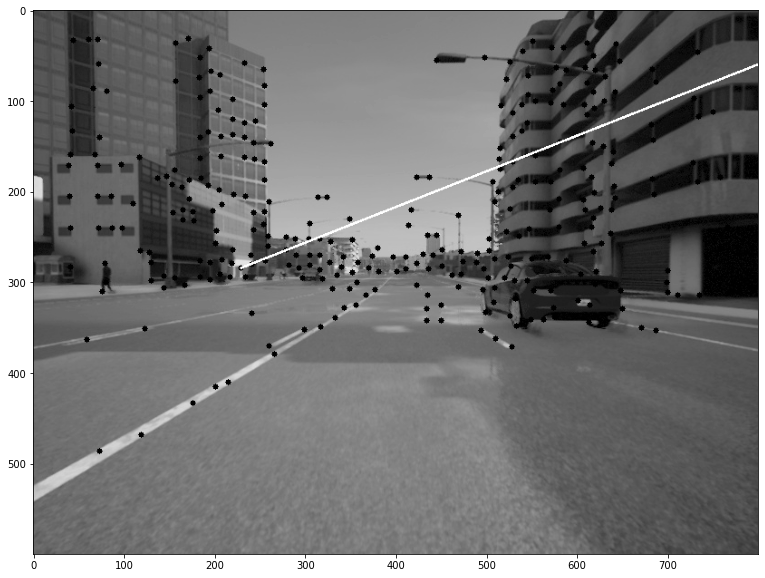

In [ ]:
points_2D = imagepoints
dist_coeffs = np.zeros((4,1))
img = img_A_t1.copy()
nose_end_point2D, jacobian = cv.projectPoints(np.array([(0.0, 0.0, 1000.0)]),
                                               rvec,
                                               tvec,
                                               k,
                                               dist_coeffs)

for p in points_2D:
  cv.circle(img, (int(p[0]), int(p[1])), 3, (0,0,255), -1)

point1 = ( int(points_2D[0][0]), int(points_2D[0][1]))
point2 = ( int(nose_end_point2D[0][0][0]), int(nose_end_point2D[0][0][1]))
cv.line(img, point1, point2, (255,255,255), 2)
 
plt.imshow(img, 'gray')

In [ ]:
print("R \n", rmat)
print("t \n", tvec)

R = rmat.transpose()
pos = -R * tvec

print("pos \n", pos)

# roll = np.atan2(-R[2][1], R[2][2])
# pitch = np.asin(R[2][0])
# yaw = np.atan2(-R[1][0], R[0][0])


R 
 [[-0.69650914 -0.62821776 -0.3467239 ]
 [-0.65717511  0.36448739  0.65974981]
 [-0.28809006  0.68738009 -0.66671788]]
t 
 [[ -10.75262816]
 [-170.50691894]
 [ 261.95323908]]
pos 
 [[  -7.48930383   -7.06635964   -3.09772527]
 [-107.11547449   62.14762205  117.20306142]
 [  90.82544763 -172.82359952  174.64890774]]


In [ ]:
# Create variables for computation
trajectory = np.zeros((3, len(matches) + 1))
robot_pose = np.zeros((len(matches) + 1, 4, 4))

NameError: name 'matches' is not defined

In [ ]:
# Determine current pose from rotation and translation matrices
current_pose = np.eye(4)
current_pose[0:3, 0:3] = rmat
current_pose[0:3, 3] = tvec.T

In [ ]:
print(current_pose)

[[ 0.99999439 -0.00177435  0.00284055 -0.16865795]
 [ 0.00177772  0.99999772 -0.00118322 -0.18735217]
 [-0.00283844  0.00118827  0.99999527  0.39068676]
 [ 0.          0.          0.          1.        ]]


In [ ]:
np.linalg.inv(current_pose)

array([[ 0.99999439,  0.00177772, -0.00283844,  0.17009901],
       [-0.00177435,  0.99999772,  0.00118827,  0.18658825],
       [ 0.00284055, -0.00118322,  0.99999527, -0.39042751],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [ ]:
i=0
# Initialize camera pose
robot_pose[0] = np.eye(4)
# Build the robot's pose from the initial position by multiplying previous and current poses
robot_pose[i + 1] = robot_pose[i] @ np.linalg.inv(current_pose)

In [ ]:
# Calculate current camera position from origin
position = robot_pose[i + 1] @ np.array([0., 0., 0., 1.])


In [ ]:
# Build trajectory
trajectory[:, i + 1] = position[0:3]


visualize_trajectory(trajectory)